## 2D Image Transformation Demo
    - Shows how to apply 2D transforms in MONAI

In [355]:
from monai.transforms import Affine, Rand2DElastic, CropForeground, LoadImage, Compose, ScaleIntensity, EnsureType
from monai.config import print_config
from monai.apps import download_and_extract
from monai.data import ImageReader, ImageDataset
import torch
import PIL
import numpy as np
import matplotlib.pyplot as plt
import tempfile
import shutil
import os
import pydicom

In [39]:
print_config()

MONAI version: 0.6.0+38.gf6ad4ba5
Numpy version: 1.21.1
Pytorch version: 1.9.0
MONAI flags: HAS_EXT = False, USE_COMPILED = False
MONAI rev id: f6ad4ba5c2a6ecd8ab0ca18da1c20b0112a18d87

Optional dependencies:
Pytorch Ignite version: 0.4.5
Nibabel version: 3.2.1
scikit-image version: 0.18.2
Pillow version: 8.3.1
Tensorboard version: 2.5.0
gdown version: 3.13.0
TorchVision version: 0.10.0+cu111
tqdm version: 4.61.2
lmdb version: 1.2.1
psutil version: 5.8.0
pandas version: 1.3.0
einops version: 0.3.0

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



In [40]:
directory = "monai_data/"
root_dir = tempfile.mkdtemp() if directory is None else directory
print(root_dir)

monai_data/


## Download dataset
    - Dataset from https://warwick.ac.uk/fac/sci/dcs/research/tia/glascontest/
    - Colon Histology Images (For research purposes only)

In [41]:
resource = "https://warwick.ac.uk/fac/sci/dcs/research/tia/" \
    + "glascontest/download/warwick_qu_dataset_released_2016_07_08.zip"
md5 = None

compressed_file = os.path.join(
    root_dir, "warwick_qu_dataset_released_2016_07_08.zip")
data_dir = os.path.join(root_dir, "Warwick QU Dataset (Released 2016_07_08)")
if not os.path.exists(data_dir):
    download_and_extract(resource, compressed_file, root_dir, md5)

In [42]:
img_name = os.path.join(data_dir, "train_22.bmp")
seg_name = os.path.join(data_dir, "train_22_anno.bmp")
im = np.array(PIL.Image.open(img_name))
seg = np.array(PIL.Image.open(seg_name))

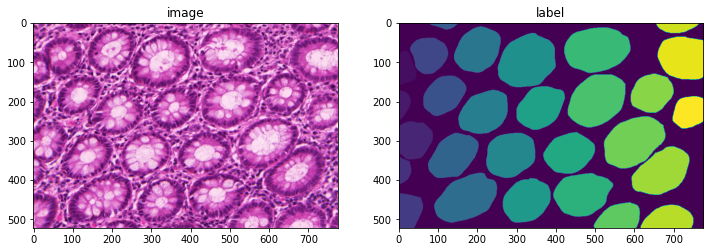

(522, 775, 3) (522, 775)


In [43]:
plt.figure("check", (12, 6))
plt.subplot(1, 2, 1)
plt.title("image")
plt.imshow(im)
plt.subplot(1, 2, 2)
plt.title("label")
plt.imshow(seg)
plt.show()
print(im.shape, seg.shape)

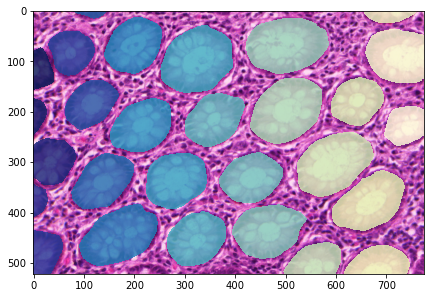

In [44]:
maskseg = np.ma.masked_where(seg == 0, seg)
fig = plt.figure(frameon=False, figsize=(7,7))
plt.imshow(im)
plt.imshow(maskseg, cmap='YlGnBu_r', alpha=0.8)

## Affine Transformation

In [45]:
# MONAI transforms always take channel-first data: [channel x H x W]
im_data = np.moveaxis(im, -1, 0)  # make them channel first
seg_data = np.expand_dims(seg, 0)  # make a channel for the segmentation

# create an Affine transform
affine = Affine(
    rotate_params=np.pi / 4,
    scale_params=(1.2, 1.2),
    translate_params=(200, 40),
    padding_mode="zeros",
    device=torch.device("cuda:0"),
)
# convert both image and segmentation using different interpolation mode
new_img, _ = affine(im_data, (300, 400), mode="bilinear")
new_seg, _ = affine(seg_data, (300, 400), mode="nearest")
print(new_img.shape, new_seg.shape)

(3, 300, 400) (1, 300, 400)


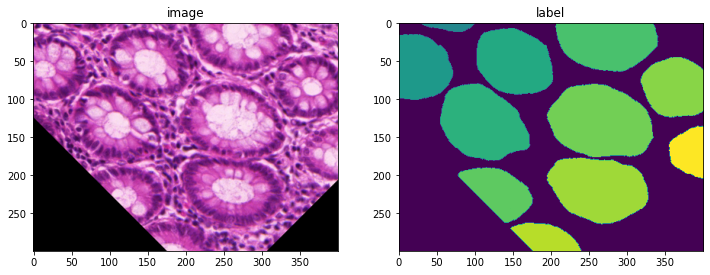

In [46]:
plt.figure("check", (12, 6))
plt.subplot(1, 2, 1)
plt.title("image")
plt.imshow(np.moveaxis(new_img.astype(int), 0, -1))
plt.subplot(1, 2, 2)
plt.title("label")
plt.imshow(new_seg[0].astype(int))
plt.show()

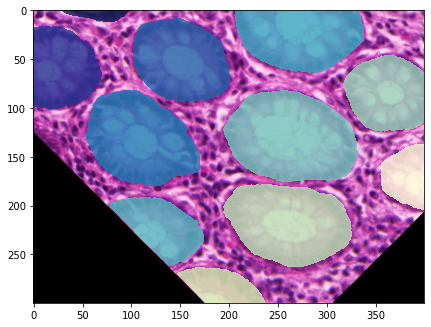

In [47]:
new_maskseg = np.ma.masked_where(new_seg == 0, new_seg)
fig = plt.figure(frameon=False, figsize=(7,7))
plt.imshow(np.moveaxis(new_img.astype(int), 0, -1))
plt.imshow(new_maskseg[0], cmap='YlGnBu_r', alpha=0.8)

## Elastic deformation

In [48]:
# create an elsatic deformation transform
deform = Rand2DElastic(
    prob=1.0,
    spacing=(30, 30),
    magnitude_range=(5, 6),
    rotate_range=(np.pi / 4,),
    scale_range=(0.2, 0.2),
    translate_range=(100, 100),
    padding_mode="zeros",
    device=torch.device("cuda:0"),
)
# transform both image and segmentation using different interpolation mode
deform.set_random_state(seed=123)
new_img = deform(im_data, (224, 224), mode="bilinear")
deform.set_random_state(seed=123)
new_seg = deform(seg_data, (224, 224), mode="nearest")
print(new_img.shape, new_seg.shape)

(3, 224, 224) (1, 224, 224)


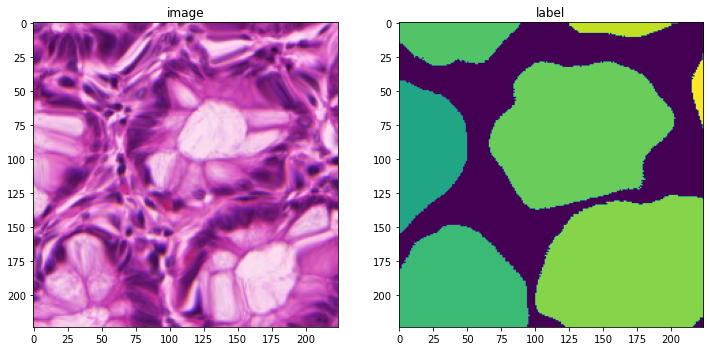

In [49]:
plt.figure("check", (12, 6))
plt.subplot(1, 2, 1)
plt.title("image")
plt.imshow(np.moveaxis(new_img.astype(int), 0, -1))
plt.subplot(1, 2, 2)
plt.title("label")
plt.imshow(new_seg[0].astype(int))
plt.show()

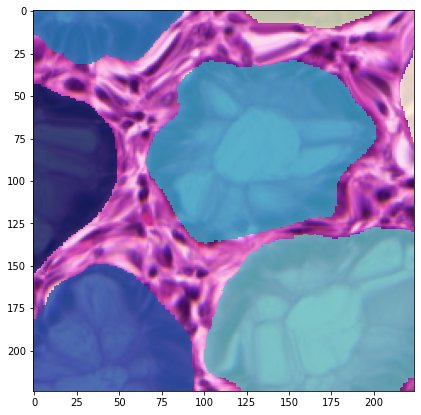

In [50]:
new_maskseg = np.ma.masked_where(new_seg == 0, new_seg)
fig = plt.figure(frameon=False, figsize=(7,7))
plt.imshow(np.moveaxis(new_img.astype(int), 0, -1))
plt.imshow(new_maskseg[0], cmap='YlGnBu_r', alpha=0.8)

## Scale Intensity of DICOM image
 - Can use Compose to apply transforms
 - Apply transforms when loading image data

In [336]:
dcmimg = ['monai_data/DCM/65761e66de9f.dcm']

In [338]:
origimg = pydicom.dcmread(dcmimg[0])

In [339]:
origimg.pixel_array

array([[1392, 1389, 1390, ...,    0,    0,    0],
       [1377, 1411, 1370, ...,    0,    0,    0],
       [1373, 1397, 1401, ...,    0,    0,    0],
       ...,
       [   0,    0,    0, ..., 2476, 2490, 2453],
       [   0,    0,    0, ..., 2515, 2541, 2509],
       [   0,    0,    0, ..., 2517, 2489, 2488]], dtype=uint16)

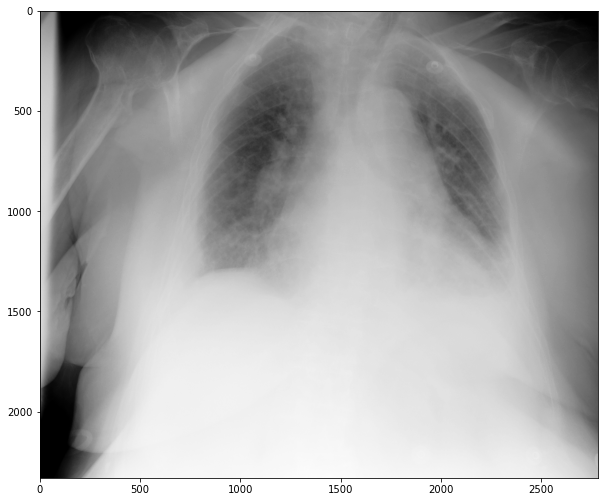

In [343]:
fig = plt.figure(frameon=False, figsize=(10,10))
plt.imshow(origimg.pixel_array, cmap='Greys_r')

In [344]:
transforms = Compose(
    [
        ScaleIntensity(), #Scales intensity
        EnsureType(), #Creates a tensor out of data
    ]
)

In [345]:
img = ImageDataset(dcmimg, transform=transforms, ImageOnly=True)

### We have scaled the intensity and created a tensor ready for input as training

In [353]:
img[0]

tensor([[[0.3687],
         [0.3648],
         [0.3637],
         ...,
         [0.0000],
         [0.0000],
         [0.0000]],

        [[0.3679],
         [0.3738],
         [0.3701],
         ...,
         [0.0000],
         [0.0000],
         [0.0000]],

        [[0.3682],
         [0.3629],
         [0.3711],
         ...,
         [0.0000],
         [0.0000],
         [0.0000]],

        ...,

        [[0.0000],
         [0.0000],
         [0.0000],
         ...,
         [0.6559],
         [0.6662],
         [0.6668]],

        [[0.0000],
         [0.0000],
         [0.0000],
         ...,
         [0.6596],
         [0.6731],
         [0.6593]],

        [[0.0000],
         [0.0000],
         [0.0000],
         ...,
         [0.6498],
         [0.6646],
         [0.6591]]])

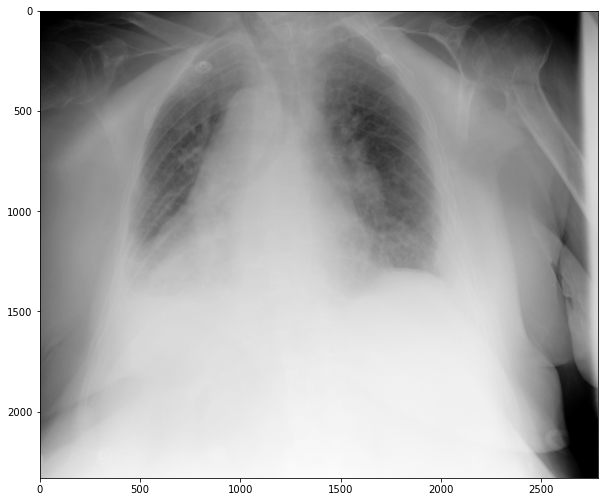

In [354]:
fig = plt.figure(frameon=False, figsize=(10,10))
plt.imshow(np.rot90(img[0].numpy()[:,:,0], 3), cmap='Greys_r')